In [1]:
%load_ext lab_black
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd

import pandas as pd
import numpy as np
import scipy.stats as stats

import plotly
import kaleido
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from statsmodels.tools import add_constant

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

from datetime import date
import glob
from collections import defaultdict


# customized modules

from src.data_models.stat_linear_regression import MyLR, get_SLR_analysis_results
from src.data_models.model_eval import RMSE, R2, MAPE, MPE, get_cv_results
from src.common_helpers.helpers import (
    select_k,
    get_k_fold_index_list,
    dict_to_dataframe,
    listStr_to_list,
)
from src.data_prepare.data_loader import load_data

# 0. Load data

In [3]:
Y_COL_NAME = "total_deposits_from_non-bank_customer"

In [4]:
model_res_dict = defaultdict(
    lambda: {"model_description": None, "x_names": None, "metrics": {}}
)

In [5]:
## Load original dataframe

file_names = sorted(glob.glob("analyze-dataset/merged_data_*.csv"))

original_filename = file_names[-1]

# use cyclical encoding for quarter number


# to avoid data leakage for model evaluation
insample_df, outsample_df, full_df = load_data(
    original_filename, insample_end_year=2017
)


# to avoid SettingWithCopyWarning
insample_df = insample_df.copy()
outsample_df = outsample_df.copy()


# cycling encoding for quarter number
insample_df["Qrt"] = (
    insample_df["Qrt"]
    .apply(lambda x: np.sin(x * (1 / 4) * (2 * np.pi)))
    .astype("int32")
)

INSAMPLE_ROWS = insample_df.shape[0]
OUTSAMPLE_ROWS = outsample_df.shape[0]


print("insample: ", insample_df.shape)
print("outsample: ", outsample_df.shape)

insample:  (104, 25)
outsample:  (14, 25)


- Plot autocorrelation plot, select lags with correlation > 0.8 as inputs of linear regression.

The Autocorreleation plot for the data is:


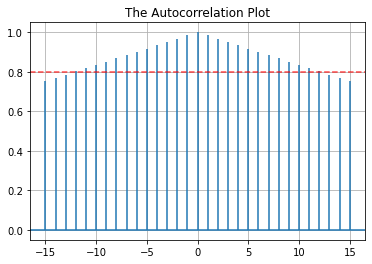

In [6]:
plt.figure()
plt.title("The Autocorrelation Plot")
plt.acorr(insample_df[Y_COL_NAME], maxlags=15)
plt.axhline(y=0.8, color="r", linestyle="--", alpha=0.7)
print("The Autocorreleation plot for the data is:")
plt.grid(True)
plt.show()

- Add Lag columns to full dataframe, according to autocorrelation

In [7]:
full_lag_df = full_df.copy()

for i in range(1, 13):
    full_lag_df[f"y_lag_{i}"] = full_lag_df[Y_COL_NAME].shift(i)

full_lag_df.head()

insample_lag_df = full_lag_df.iloc[:INSAMPLE_ROWS]  # contain nan values
insample_lag_df = insample_lag_df.dropna()  # remove nan values
outsample_lag_df = full_lag_df.iloc[-OUTSAMPLE_ROWS:]

# display(insample_lag_df)
# display(outsample_lag_df)
print(insample_lag_df.shape)
print(outsample_lag_df.shape)

(92, 37)
(14, 37)


# 1. Linear Model

## 1.1 Simple Linear Model

In [8]:
SLR_df = insample_lag_df.copy()

# display(SLR_df.head())
print(SLR_df.shape)

(92, 37)


- For each single variable, build a simple linear regression model (excluding nan-value rows), collect corresponding metrics.

In [9]:
X = SLR_df.iloc[:, 2:].copy()

y = SLR_df[Y_COL_NAME].copy()

SLR_analysis_res_df = get_SLR_analysis_results(X, y)

print("================ SLR result ===================")
print("Shape of simple linear model", SLR_analysis_res_df.shape)

# SLR_analysis_res_df

================ SLR result ===================
Shape of simple linear model (35, 13)


In [10]:
# create short name conversion for each variable

X_to_alias_dict = {k: f"V_{i+1}" for (i, k) in enumerate(X.columns)}
alias_to_X_dict = {v: k for k, v in X_to_alias_dict.items()}

### Plot Bar chart of R-squared for simple linear regression  

The bar chart has shown that **Vxxx** has lowest R-squared metric for simple linear regression.   
Correspondingly, **Vxx** got relatively higher p-values.  

- [sns color palettee guide](https://medium.com/@morganjonesartist/color-guide-to-seaborn-palettes-da849406d44f)

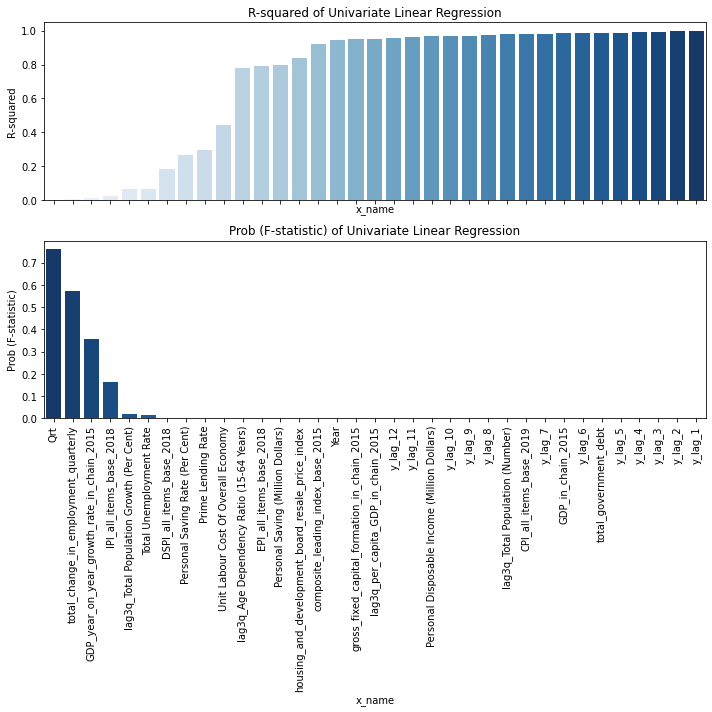

In [11]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(10, 10))
ax1, ax2 = axs.flat
plt.xticks(rotation=90)


num_colors = SLR_analysis_res_df.shape[0]

#### Plot R-squared ####
## color follow the R-squared value

pal = sns.color_palette("Blues", n_colors=num_colors)
pal_r = sns.color_palette("Blues_r", n_colors=num_colors)


rank = (
    SLR_analysis_res_df["R-squared"].argsort().argsort()
)  # http://stackoverflow.com/a/6266510/1628638


plot1 = sns.barplot(
    ax=ax1,
    x="x_name",
    y="R-squared",
    data=SLR_analysis_res_df,
    palette=pal,
    order=SLR_analysis_res_df.sort_values("R-squared")["x_name"],
)

ax1.set_title("R-squared of Univariate Linear Regression")

#### Plot p-values ####


plot2 = sns.barplot(
    ax=ax2,
    x="x_name",
    y="Prob (F-statistic)",
    data=SLR_analysis_res_df,
    palette=pal_r,
    order=SLR_analysis_res_df.sort_values("R-squared")["x_name"],
)

ax2.set_title("Prob (F-statistic) of Univariate Linear Regression")

plt.tight_layout()
plt.savefig("./output/linear_model/univariate_LR.png")
plt.show()

- use best univariate model on test dataset

In [61]:
current_train_X = insample_lag_df[["y_lag_1"]]
current_train_y = insample_lag_df[Y_COL_NAME]

mySLR = MyLR(train_X=current_train_X, train_y=current_train_y)
metrics_df = mySLR.get_train_eval()
display(metrics_df)

train_rmse = RMSE(current_train_y, mySLR.train_predict_y)
train_r2 = float(metrics_df["R-squared"].values[0])


# test dataset
current_test_X = outsample_lag_df[["y_lag_1"]]
current_test_y = outsample_lag_df[Y_COL_NAME]
current_test_predict_y = mySLR.predict(X=current_test_X)

test_rmse = RMSE(current_test_y, current_test_predict_y)
test_r2 = R2(current_test_y, current_test_predict_y)

print("", train_rmse, train_r2, test_rmse, test_r2)

,Model,Dependent Variable,Date,No. Observations,Df Model,Df Residuals,R-squared,Adj. R-squared,AIC,BIC,Log-Likelihood,F-statistic,Prob (F-statistic),Scale
1,OLS,total_deposits_from_non-bank_customer,2022-09-19 10:44,92,1,90,0.999,0.999,2044.6513,2049.6949,-1020.3,9.251e+04,2.33e-137,2.5713e+08


 15860.03633972216 0.999 29322.71224467604 0.9734394079448805


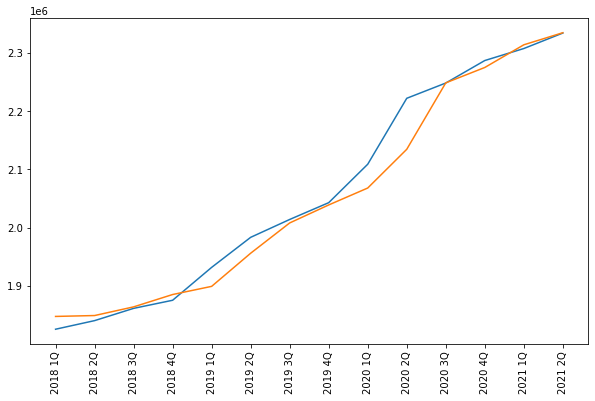

In [62]:
temp_df = pd.DataFrame([current_test_y, current_test_predict_y]).T
temp_df.columns = ["y", "fit_y"]
temp_df["diff"] = temp_df["fit_y"] - temp_df["y"]

temp_df

plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
plt.plot(outsample_lag_df["Data Series"], temp_df["y"])
plt.plot(outsample_lag_df["Data Series"], temp_df["fit_y"])
plt.show()

## 1.2 Multiple Linear Model  

- [Cross Validation in Machine Learning using StatsModels and Sklearn with Logistic Regression Example](https://medium.com/analytics-vidhya/cross-validation-in-machine-learning-using-python-4d0f335bec83)  
- [How to Selecting Predictors](https://otexts.com/fpp2/selecting-predictors.html)  
- [statsmodel wrapper for sklearn cross-validation](https://stackoverflow.com/questions/41045752/using-statsmodel-estimations-with-scikit-learn-cross-validation-is-it-possible)

In [35]:
MLR_df = insample_lag_df.copy()

### 1.2.1 Multiple Linear Regression: all variables, feature importance measured by **coefficient**.

In [36]:
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing

In [37]:
min_max_scaler = preprocessing.MinMaxScaler()
normalized_MLR_df = min_max_scaler.fit_transform(MLR_df.iloc[:, 1:])


# normalized before linear regression since coefficient will be used as feature importance
X = normalized_MLR_df[:, 1:]
y = normalized_MLR_df[:, 0]

## create alias for independent variables

sk_LR_model = LinearRegression()
# fit the model
sk_LR_model.fit(X, y)
# get importance
importance = sk_LR_model.coef_

importance

array([-0.01750288, -0.01572047,  0.0342522 , -0.0472345 , -0.01450819,
        0.03140466, -0.00984588, -0.06759901, -0.04952022,  0.12082433,
       -0.06341504,  0.0844871 , -0.01412065, -0.00688606,  0.05115189,
        0.00919368,  0.16555294, -0.02112538,  0.00620366, -0.03540297,
        0.01193989, -0.12693863, -0.00520664,  1.11653144, -0.22300172,
       -0.16525161,  0.1930421 , -0.15040037,  0.01605728,  0.14656727,
       -0.11807372,  0.12431537, -0.15427669, -0.08485968,  0.08811337])

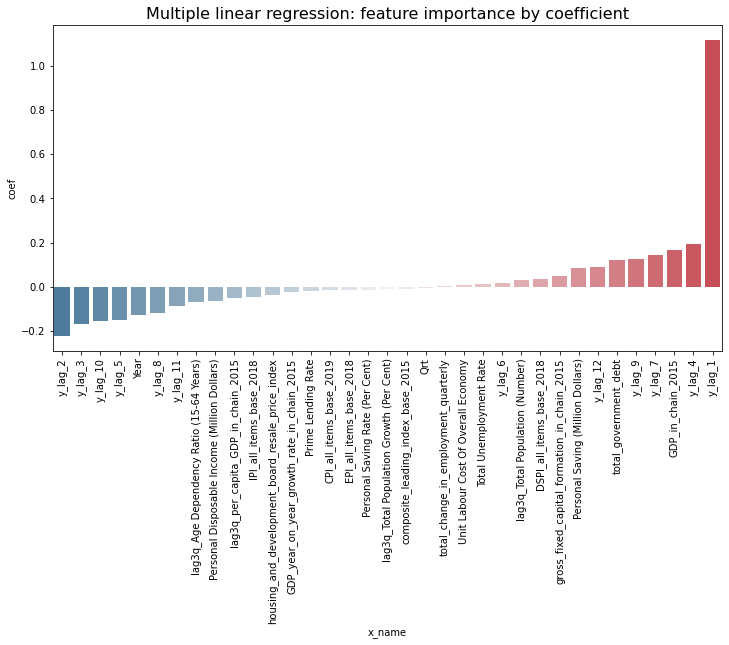

In [38]:
x_labels = MLR_df.columns[2:]
x = range(len(importance))

temp_df = pd.DataFrame([x_labels, importance]).T
temp_df.columns = ["x_name", "coef"]


plt.figure(figsize=(12, 6))
plt.title("Multiple linear regression: feature importance by coefficient", fontsize=16)

pal = sns.diverging_palette(240, 10, n=SLR_analysis_res_df.shape[0])

rank = np.abs(importance).argsort().argsort()
plt.xticks(rotation=90)

plot = sns.barplot(
    x="x_name",
    y="coef",
    data=temp_df,
    # palette=np.array(pal)[rank],
    palette=pal,
    order=temp_df.sort_values("coef")["x_name"],
)

plt.savefig("./output/linear_model/multivariate_LR_feature_importance")
plt.show()

### 1.2.2 Stepwise Regression: Backward elimination  

- [metrics string](https://scikit-learn.org/stable/modules/model_evaluation.html)

In [39]:
#### using all features
y_name = Y_COL_NAME
x_names = list(MLR_df.columns[2:])

lr_model = LinearRegression()
res_dict = get_cv_results(lr_model, MLR_df, y_name, x_names)
res_df = dict_to_dataframe(res_dict)

res_df

,train_R2,test_R2,train_RMSE,test_RMSE,train_MPE,test_MPE,train_MAPE,test_MAPE
0,0.999739,0.998662,8198.555739,18102.669637,0.000184,0.000877,0.00913,0.019091


In [40]:
y_name = Y_COL_NAME
current_x_columns = list(MLR_df.columns[2:])
k = len(current_x_columns)
criteria_metric = "test_MAPE"

# record best model for k, k = 1,2,...,K
best_k_df_ls = []

# a linear regression model
lr_model = LinearRegression()

### add model using all variables first
print(
    f"============================ Feature Subset Size: {k} ================================="
)
# print(f"number of candidates: 1")
cv_eval_df = get_cv_results(lr_model, MLR_df, y_name, list(current_x_columns))
cv_eval_df["columns"] = str(list(current_x_columns))
cv_eval_df["subset_size"] = k
cv_eval_df["removed"] = "None"
best_k_df_ls.append(dict_to_dataframe(cv_eval_df))


# backwards elimination
while k > 1:

    print(
        f"============================ Feature Subset Size: {k-1} ================================="
    )

    # 1. get all (k-1) combinations
    current_x_combination = select_k(current_x_columns, k - 1)

    # 2. get evaluation metrics for each subset
    temp_eval_ls = []
    for current_x in current_x_combination:

        cv_eval_df = get_cv_results(lr_model, MLR_df, y_name, list(current_x))

        cv_eval_df["columns"] = str(list(current_x))
        cv_eval_df["subset_size"] = k - 1

        temp_eval_ls.append(dict_to_dataframe(cv_eval_df))

    # summary of all (k-1) models
    temp_eval_df = pd.concat(temp_eval_ls)

    # 3. get the one with maximum metric value
    best_k_df = temp_eval_df[
        temp_eval_df[criteria_metric] == temp_eval_df[criteria_metric].max()
    ].copy()

    # 4. get the best (k-1) x_names
    best_k_columns = listStr_to_list(best_k_df["columns"].values[0])

    # 5. record the feature removed for this round
    removed = [x for x in current_x_columns if x not in best_k_columns]
    best_k_df["removed"] = removed

    # 6. record best model for this round
    best_k_df_ls.append(best_k_df)

    # 7. enter next round
    current_x_columns = best_k_columns
    k = k - 1


best_k_summary = pd.concat(best_k_df_ls).reset_index(drop=True)

display(best_k_summary)

============================ Feature Subset Size: 35 =================================
============================ Feature Subset Size: 34 =================================
============================ Feature Subset Size: 33 =================================
============================ Feature Subset Size: 32 =================================
============================ Feature Subset Size: 31 =================================
============================ Feature Subset Size: 30 =================================
============================ Feature Subset Size: 29 =================================
============================ Feature Subset Size: 28 =================================
============================ Feature Subset Size: 27 =================================
============================ Feature Subset Size: 26 =================================
============================ Feature Subset Size: 25 =================================
============================ Feature Subset

,train_R2,test_R2,train_RMSE,test_RMSE,train_MPE,test_MPE,train_MAPE,test_MAPE,columns,subset_size,removed
0,0.999739,0.998662,8198.555739,18102.669637,0.000184,0.000877,0.009130,0.019091,"['Prime Lending Rate', 'CPI_all_items_base_201...",35,None
1,0.999365,0.998180,12803.881977,21175.838393,0.000292,0.001590,0.013780,0.022744,"['Prime Lending Rate', 'CPI_all_items_base_201...",34,y_lag_1
2,0.999270,0.997899,13725.734051,22926.495425,0.000306,0.000958,0.015408,0.025185,"['Prime Lending Rate', 'CPI_all_items_base_201...",33,y_lag_2
3,0.999009,0.997005,15996.301623,27114.339383,0.000135,0.001490,0.017884,0.029329,"['Prime Lending Rate', 'CPI_all_items_base_201...",32,total_government_debt
4,0.998698,0.996303,18330.573341,30156.984400,0.000170,0.002628,0.019836,0.031551,"['Prime Lending Rate', 'CPI_all_items_base_201...",31,GDP_in_chain_2015
5,0.998390,0.996006,20377.668294,31631.144919,0.000434,0.003390,0.021813,0.034405,"['Prime Lending Rate', 'CPI_all_items_base_201...",30,EPI_all_items_base_2018
6,0.997981,0.995432,22839.669622,33834.053751,0.000444,0.003309,0.025655,0.038184,"['Prime Lending Rate', 'CPI_all_items_base_201...",29,y_lag_3
7,0.997556,0.994592,25128.661519,36734.362078,0.000630,0.004325,0.028367,0.042636,"['Prime Lending Rate', 'CPI_all_items_base_201...",28,composite_leading_index_base_2015
8,0.996972,0.993310,27959.478972,40790.805187,0.000695,0.003965,0.032221,0.046904,"['Prime Lending Rate', 'CPI_all_items_base_201...",27,y_lag_4
9,0.996780,0.992949,28835.732476,41870.120952,0.000675,0.004408,0.035094,0.050866,"['Prime Lending Rate', 'CPI_all_items_base_201...",26,lag3q_Age Dependency Ratio (15-64 Years)


- Plot evaluation metrics for best-k subset models

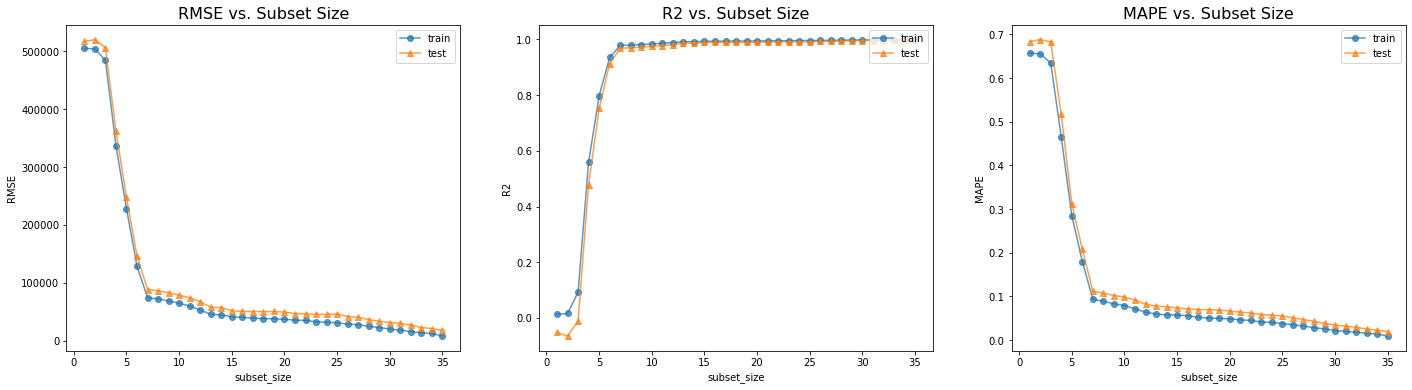

In [41]:
fig, axs = plt.subplots(1, 3, figsize=(24, 6))
axs = axs.flat

# plt.suptitle("Backwards Elimination Process", fontsize=20)

train_ls = ["train_RMSE", "train_R2", "train_MAPE"]
test_ls = ["test_RMSE", "test_R2", "test_MAPE"]

for i in range(len(train_ls)):

    axs[i].plot(
        best_k_summary["subset_size"],
        best_k_summary[train_ls[i]],
        marker="o",
        alpha=0.75,
        label="train",
    )

    axs[i].plot(
        best_k_summary["subset_size"],
        best_k_summary[test_ls[i]],
        marker="^",
        alpha=0.75,
        label="test",
    )

    axs[i].set_xlabel("subset_size")
    axs[i].set_ylabel(train_ls[i].split("_")[-1])
    axs[i].set_title(f'{train_ls[i].split("_")[-1]} vs. Subset Size', fontsize=16)
    axs[i].legend(loc="upper right")

plt.savefig("./output/linear_model/multivariate_LR_backwards_elimination.png")
plt.show()

- Get the best subset at turning point, evaluate it on the outsample dataset

In [45]:
# best_k_summary.iloc[5, :]["columns"]

x_cols = listStr_to_list(best_k_summary.iloc[5, :]["columns"])


current_train_X = insample_lag_df[x_cols]
current_train_y = insample_lag_df[Y_COL_NAME]

mySLR = MyLR(train_X=current_train_X, train_y=current_train_y)
metrics_df = mySLR.get_train_eval()
display(metrics_df)

train_rmse = RMSE(current_train_y, mySLR.train_predict_y)
train_r2 = float(metrics_df["R-squared"].values[0])


# test dataset
current_test_X = outsample_lag_df[x_cols]
current_test_y = outsample_lag_df[Y_COL_NAME]
current_test_predict_y = mySLR.predict(X=current_test_X)

test_rmse = RMSE(current_test_y, current_test_predict_y)
test_r2 = R2(current_test_y, current_test_predict_y)

print("", train_rmse, train_r2, test_rmse, test_r2)

,Model,Dependent Variable,Date,No. Observations,Df Model,Df Residuals,R-squared,Adj. R-squared,AIC,BIC,Log-Likelihood,F-statistic,Prob (F-statistic),Scale
1,OLS,total_deposits_from_non-bank_customer,2022-09-19 10:36,92,30,61,0.998,0.997,2158.9071,2237.0825,-1048.5,1133.,2.26e-73,6.9924e+08


 21532.004046687296 0.998 205751.75070423243 -0.307725381596069


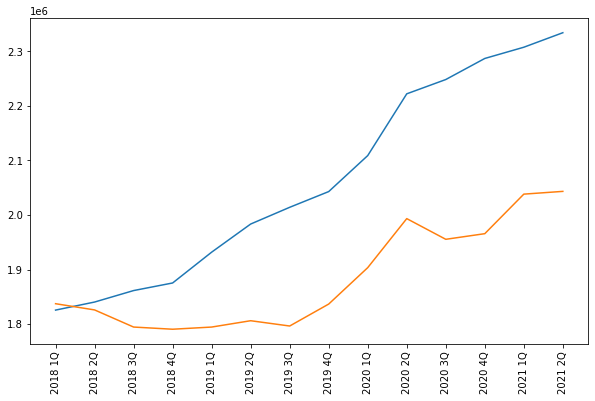

In [60]:
temp_df = pd.DataFrame([current_test_y, current_test_predict_y]).T
temp_df.columns = ["y", "fit_y"]
temp_df["diff"] = temp_df["fit_y"] - temp_df["y"]

temp_df

plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
plt.plot(outsample_lag_df["Data Series"], temp_df["y"])
plt.plot(outsample_lag_df["Data Series"], temp_df["fit_y"])
plt.show()

### 1.2.3 Feature Selection by Model: Elasticnet

In [63]:
# evaluate an elastic net model on the dataset
from numpy import mean
from numpy import std
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import ElasticNetCV

In [64]:
# define model
# model = ElasticNet(alpha=1.0, l1_ratio=0.5)
# define model evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)
# evaluate model

# define model
ratios = [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]

model = ElasticNetCV(l1_ratio=ratios, cv=cv)
# fit model
model.fit(X, y)
# summarize chosen configuration
print("alpha: %f" % model.alpha_)
print("l1_ratio_: %f" % model.l1_ratio_)

model.coef_

predict_y = model.predict(X)


MAPE(y, predict_y)

alpha: 0.000125
l1_ratio_: 0.950000


/opt/anaconda3/envs/maribank/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.668e-03, tolerance: 1.025e-03
  model = cd_fast.enet_coordinate_descent(


150120201528.72723

/opt/anaconda3/envs/maribank/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(


,y,fit_y,diff
0,1825725.9,1.573418e+06,-252307.738187
1,1840486.8,1.575125e+06,-265362.024240
2,1861532.3,1.587970e+06,-273562.330707
3,1875442.4,1.606193e+06,-269249.499588
4,1931913.1,1.618627e+06,-313286.368978
5,1983480.8,1.666530e+06,-316950.911758
6,2014147.8,1.711841e+06,-302307.030137
7,2042985.9,1.739037e+06,-303948.638552
8,2108964.4,1.764115e+06,-344849.338666
9,2222162.2,1.819925e+06,-402237.073819


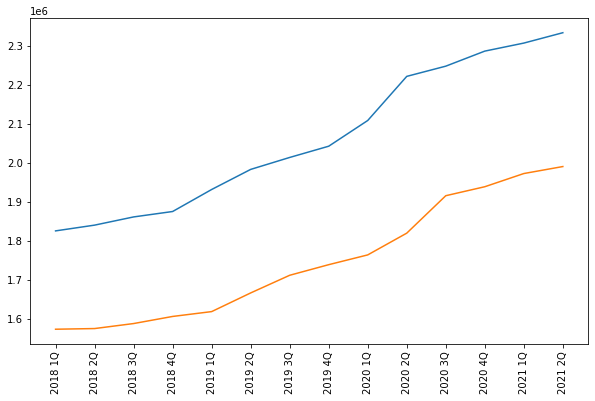

In [69]:
### test code

# best_k_summary.iloc[5, :]["columns"]

current_test_y = outsample_lag_df[Y_COL_NAME]
current_test_predict_y = model.predict(outsample_lag_df.iloc[:, 2:])


temp_df = pd.DataFrame([list(current_test_y), current_test_predict_y]).T
temp_df.columns = ["y", "fit_y"]
temp_df["diff"] = temp_df["fit_y"] - temp_df["y"]

display(temp_df)

plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
plt.plot(outsample_lag_df["Data Series"], temp_df["y"])
plt.plot(outsample_lag_df["Data Series"], temp_df["fit_y"])
plt.show()

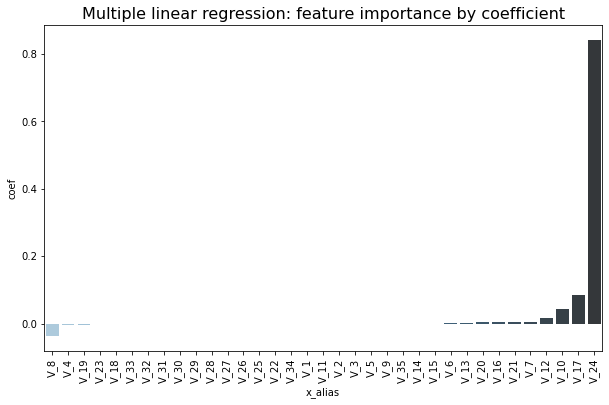

In [48]:
importance = model.coef_

x_labels = ["V_" + str(i + 1) for i in range(len(importance))]
x = range(len(importance))

temp_df = pd.DataFrame([x_labels, importance]).T
temp_df.columns = ["x_alias", "coef"]


plt.figure(figsize=(10, 6))
plt.title("Multiple linear regression: feature importance by coefficient", fontsize=16)

pal = sns.color_palette("Blues_d", SLR_analysis_res_df.shape[0])
rank = np.abs(importance).argsort().argsort()
plt.xticks(rotation=90)

plot2 = sns.barplot(
    x="x_alias",
    y="coef",
    data=temp_df,
    # palette=np.array(pal)[rank],
    palette=pal,
    order=temp_df.sort_values("coef")["x_alias"],
)

plt.savefig("./output/linear_model/multivariate_LR_feature_importance")
plt.show()